In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (2).png
/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (285).png
/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (166)_mask.png
/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (290)_mask.png
/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (300).png
/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (390).png
/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (357).png
/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (430)_mask.png
/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (89)_mask.png
/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (261)_mask.png
/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUS

In [3]:
import tensorflow as tf
import os
import random
import numpy as np
 
from tqdm import tqdm 
from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow
from skimage import metrics
from skimage.transform import resize
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from PIL import Image 
import shutil

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import random
from sklearn.model_selection import train_test_split

import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import classification_report, confusion_matrix

import seaborn as sns
from torchvision.transforms import RandomHorizontalFlip, RandomRotation, ColorJitter

labels = ['benign', 'malignant', 'normal']

2024-02-06 17:02:17.711315: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-06 17:02:17.711523: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-06 17:02:17.912591: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

In [66]:
# Set the path to the Kaggle working directory
working_dir = '/kaggle/working'

# Delete all files and subdirectories in the working directory
for item in os.listdir(working_dir):
    item_path = os.path.join(working_dir, item)
    if os.path.isfile(item_path):
        os.remove(item_path)
    elif os.path.isdir(item_path):
        shutil.rmtree(item_path)

# Confirm that the directory is empty
print("Kaggle working directory has been cleared.")

Kaggle working directory has been cleared.


In [68]:
# Function to create image folders
def create_image_folders(image_path, image_name):
    # Extract the common part of the image name (e.g., "benign (121)")
    common_name = ''.join(c for c in image_name if c.isalnum() or c.isspace()).rstrip()
    # Remove spaces and parentheses from the common name
    folder_name = common_name.replace(" ", "").replace("(", "").replace(")", "")
    image_folder = os.path.join("/kaggle/working", folder_name, "image")
    mask_folder = os.path.join("/kaggle/working", folder_name, "mask")
    os.makedirs(image_folder, exist_ok=True)
    os.makedirs(mask_folder, exist_ok=True)
    return image_folder, mask_folder

# Function to copy image and mask files to their respective folders
def copy_files(image_path, image_name, image_folder, mask_folder):
    # Find all images matching the image name (e.g., "benign (121).png")
    image_files = [f for f in os.listdir(image_path) if f.startswith(image_name) and f.endswith(".png") and "_mask" not in f]
    mask_files = [f for f in os.listdir(image_path) if f.startswith(image_name) and ("_mask" in f)]

    if image_files:
        for image_file in image_files:
            shutil.copy(os.path.join(image_path, image_file), os.path.join(image_folder, image_file))
        
        for mask_file in mask_files:
            shutil.copy(os.path.join(image_path, mask_file), os.path.join(mask_folder, mask_file))
    else:
        print(f"No image found for {image_name} in {image_path}")

# Main function to iterate through directories
def process_dataset(dataset_path):
    for root, dirs, files in os.walk(dataset_path):
        for directory in dirs:
            dir_path = os.path.join(root, directory)
            image_files = [f for f in os.listdir(dir_path) if f.endswith(".png") and "_mask" not in f]
            for file in image_files:
                image_name = os.path.splitext(file)[0]
                image_folder, mask_folder = create_image_folders("/kaggle/working", image_name)
                copy_files(dir_path, image_name, image_folder, mask_folder)

# Specify your dataset directory here
dataset_directory = "/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT"

# Call the main function to process the dataset
process_dataset(dataset_directory)

In [48]:
def count_folders(dataset_path):
    benign_count = malignant_count = normal_count = 0

    # Get a list of all directories in the dataset directory
    all_folders = os.listdir(dataset_path)

    # Count folders containing "benign", "malignant", and "normal"
    benign_count = sum(1 for folder in all_folders if "benign" in folder)
    malignant_count = sum(1 for folder in all_folders if "malignant" in folder)
    normal_count = sum(1 for folder in all_folders if "normal" in folder)

    return benign_count, malignant_count, normal_count

# Specify your dataset directory here
dataset_directory = "/kaggle/working"

# Call the function to count folders
benign_count, malignant_count, normal_count = count_folders(dataset_directory)

# Print the counts
print("Number of folders in each category:")
print("Benign:", benign_count)
print("Malignant:", malignant_count)
print("Normal:", normal_count)

Number of folders in each category:
Benign: 437
Malignant: 210
Normal: 133


In [69]:
def main():
    source_dir = "/kaggle/working"
    train_dir = os.path.join(source_dir, "train")

    # Create train directory if it doesn't exist
    os.makedirs(train_dir, exist_ok=True)

    # Move all items from source directory to train directory
    for item in os.listdir(source_dir):
        if item != "train":  # Exclude train directory itself
            shutil.move(os.path.join(source_dir, item), train_dir)

if __name__ == "__main__":
    main()

In [70]:

def move_folders(source_dir, dest_dir, folders_to_move):
    os.makedirs(dest_dir, exist_ok=True)
    for folder in folders_to_move:
        shutil.move(os.path.join(source_dir, folder), dest_dir)

def main():
    source_dir = "/kaggle/working/train"
    test_dir = "/kaggle/working/test"

    # Create test directory
    os.makedirs(test_dir, exist_ok=True)

    # Define categories
    categories = ["benign", "malignant", "normal"]

    # Move 10 random folders of each category to test directory
    for category in categories:
        folders = [f for f in os.listdir(source_dir) if category in f]
        random.shuffle(folders)  # Shuffle the folders list randomly
        folders_to_move = folders[:10]  # Select first 10 folders
        move_folders(source_dir, test_dir, folders_to_move)

if __name__ == "__main__":
    main()

In [71]:
def count_folders(dataset_path):
    benign_count = malignant_count = normal_count = 0

    # Get a list of all directories in the dataset directory
    all_folders = os.listdir(dataset_path)

    # Count folders containing "benign", "malignant", and "normal"
    benign_count = sum(1 for folder in all_folders if "benign" in folder)
    malignant_count = sum(1 for folder in all_folders if "malignant" in folder)
    normal_count = sum(1 for folder in all_folders if "normal" in folder)

    return benign_count, malignant_count, normal_count

# Specify your dataset directory here
dataset_directory = "/kaggle/working/test"

# Call the function to count folders
benign_count, malignant_count, normal_count = count_folders(dataset_directory)

# Print the counts
print("Number of folders in each category:")
print("Benign:", benign_count)
print("Malignant:", malignant_count)
print("Normal:", normal_count)

Number of folders in each category:
Benign: 10
Malignant: 10
Normal: 10


In [74]:
def rename_files(root_dir):
    for root, dirs, files in os.walk(root_dir):
        for filename in files:
            new_filename = filename.replace(" ", "").replace("(", "").replace(")", "")
            os.rename(os.path.join(root, filename), os.path.join(root, new_filename))

def main():
    train_dir = "/kaggle/working/train"
    test_dir = "/kaggle/working/test"

    # Rename files in train directory
    rename_files(train_dir)

    # Rename files in test directory
    rename_files(test_dir)

if __name__ == "__main__":
    main()

In [75]:
def list_files_with_multiple_masks(root_dir):
    for root, dirs, files in os.walk(root_dir):
        for dir_name in dirs:
            mask_folder = os.path.join(root, dir_name, "mask")
            if os.path.exists(mask_folder) and len(os.listdir(mask_folder)) > 1:
                print(f"Files in mask folder with more than one item in folder {os.path.join(root, dir_name)}:")
                for filename in os.listdir(mask_folder):
                    print(os.path.join(mask_folder, filename))
                print()

def main():
    train_dir = "/kaggle/working/train"
    list_files_with_multiple_masks(train_dir)

if __name__ == "__main__":
    main()

Files in mask folder with more than one item in folder /kaggle/working/train/benign92:
/kaggle/working/train/benign92/mask/benign92_mask.png
/kaggle/working/train/benign92/mask/benign92_mask_1.png

Files in mask folder with more than one item in folder /kaggle/working/train/benign100:
/kaggle/working/train/benign100/mask/benign100_mask.png
/kaggle/working/train/benign100/mask/benign100_mask_1.png

Files in mask folder with more than one item in folder /kaggle/working/train/benign58:
/kaggle/working/train/benign58/mask/benign58_mask_1.png
/kaggle/working/train/benign58/mask/benign58_mask.png

Files in mask folder with more than one item in folder /kaggle/working/train/benign98:
/kaggle/working/train/benign98/mask/benign98_mask_1.png
/kaggle/working/train/benign98/mask/benign98_mask.png

Files in mask folder with more than one item in folder /kaggle/working/train/benign424:
/kaggle/working/train/benign424/mask/benign424_mask_1.png
/kaggle/working/train/benign424/mask/benign424_mask.png



In [82]:
TRAIN_PATH = '/kaggle/working/train/'
TEST_PATH = '/kaggle/working/test/'

train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]
# print(train_ids)

In [101]:

# Function to preprocess training data
def preprocess_train_data(train_ids):
    Xtrain = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    Ytrain = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

    print('Resizing training images and masks')
    for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
        path = TRAIN_PATH + id_
        img = imread(path + '/image/' + id_ + '.png')[:,:,:IMG_CHANNELS]  
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        Xtrain[n] = img  # Fill empty X_train with values from img
        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
        for mask_file in next(os.walk(path + '/mask/'))[2]:
            mask_ = imread(path + '/mask/' + mask_file)
            # Convert mask to grayscale if it's in RGB format
            if len(mask_.shape) == 3 and mask_.shape[-1] == 3:
                mask_ = np.mean(mask_, axis=-1, keepdims=True)
            mask_ = resize(mask_, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)
            mask = np.maximum(mask, mask_)
        Ytrain[n] = mask

    return Xtrain, Ytrain

# Function to preprocess test data
def preprocess_test_data(test_ids):
    Xtest = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    Ytest = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
    
    print('Resizing test images') 
    for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
        path = TEST_PATH + id_
        img = imread(path + '/image/' + id_ + '.png')[:,:,:IMG_CHANNELS]
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        Xtest[n] = img
        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
        for mask_file in next(os.walk(path + '/mask/'))[2]:
            mask_ = imread(path + '/mask/' + mask_file)
            # Convert mask to grayscale if it's in RGB format
            if len(mask_.shape) == 3 and mask_.shape[-1] == 3:
                mask_ = np.mean(mask_, axis=-1, keepdims=True)
            mask_ = resize(mask_, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)
            mask = np.maximum(mask, mask_)
        Ytest[n] = mask

    return Xtest, Ytest

# Preprocess training data
Xtrain, Ytrain = preprocess_train_data(train_ids)

# Preprocess test data
Xtest, Ytest = preprocess_test_data(test_ids)

print('Done!')

Resizing training images and masks


100%|██████████| 750/750 [00:48<00:00, 15.48it/s]


Resizing test images


100%|██████████| 30/30 [00:02<00:00, 14.44it/s]

Done!


In [108]:
np.save('xtrain.npy',Xtrain)
np.save('ytrain.npy',Ytrain)
np.save('xtest.npy',Xtest)
np.save('ytest.npy',Ytest)

In [109]:
Xtrain=np.load("xtrain.npy")
Ytrain=np.load("ytrain.npy")
Xtest=np.load("xtest.npy")
Ytest=np.load("ytest.npy")

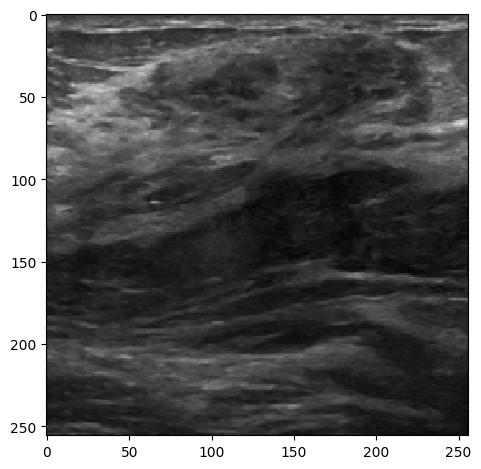

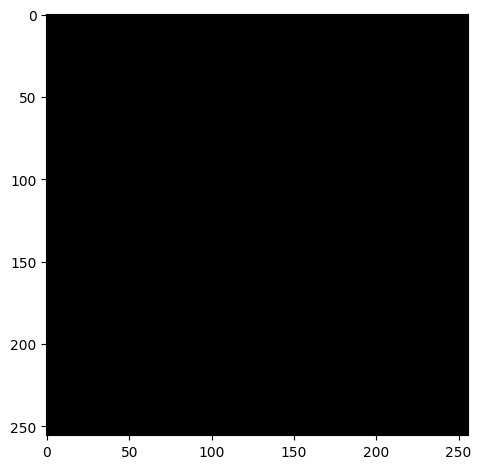

687


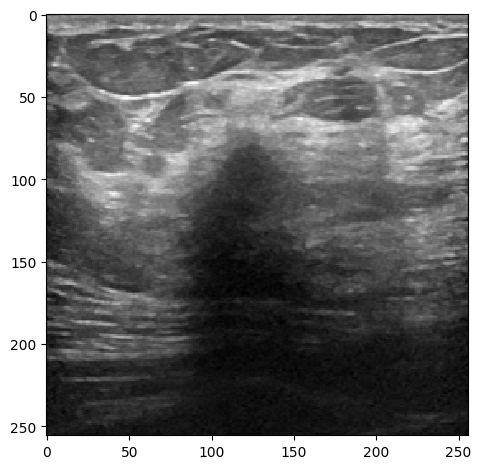

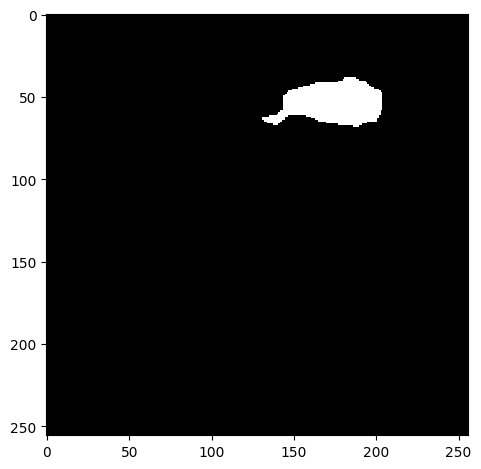

29


In [111]:

imagex = random.randint(0, len(train_ids)-1)
imshow(Xtrain[imagex])
plt.show()
y=Ytrain[imagex].astype(np.float32)
imshow(np.squeeze(y))
plt.show()
print(imagex)

imagex = random.randint(0, len(test_ids)-1)
imshow(Xtest[imagex])
plt.show()
y=Ytest[imagex].astype(np.float32)
imshow(np.squeeze(y))
plt.show()
print(imagex)

In [112]:
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

function=["relu"]
i=0;
optimizers=["adam"]
j=0;
#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation=function[i], kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation=function[i], kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation=function[i], kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation=function[i], kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation=function[i], kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation=function[i], kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation=function[i], kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation=function[i], kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation=function[i], kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation=function[i], kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation=function[i], kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation=function[i], kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation=function[i], kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation=function[i], kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation=function[i], kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation=function[i], kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation=function[i], kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation=function[i], kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer=optimizers[j], loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 lambda (Lambda)             (None, 256, 256, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['lambda[0][0]']              
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 16)         0         ['conv2d[0][0]']              
                                                                                              

In [114]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.h5', verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

results = model.fit(Xtrain, Ytrain,batch_size=16,validation_split=0.1, epochs=2, callbacks=callbacks)
model.save("Model")

Epoch 1/2
43/43 [==============================] - 265s 6s/step - loss: 0.2249 - accuracy: 0.9176 - val_loss: 0.1941 - val_accuracy: 0.9281
Epoch 2/2
43/43 [==============================] - 264s 6s/step - loss: 0.2208 - accuracy: 0.9210 - val_loss: 0.1841 - val_accuracy: 0.9368


In [115]:
model = tf.keras.models.load_model("Model")
model.compile()

In [117]:
import math

1/1 [==============================] - 3s 3s/step
0.10876   0.04246   0.18571   79.328


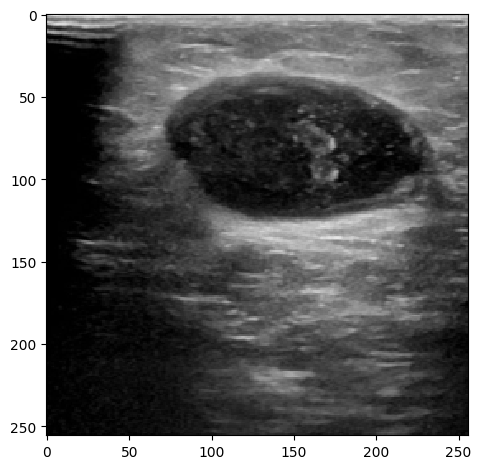

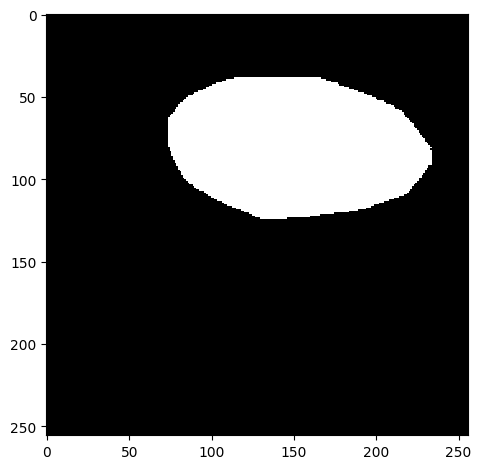

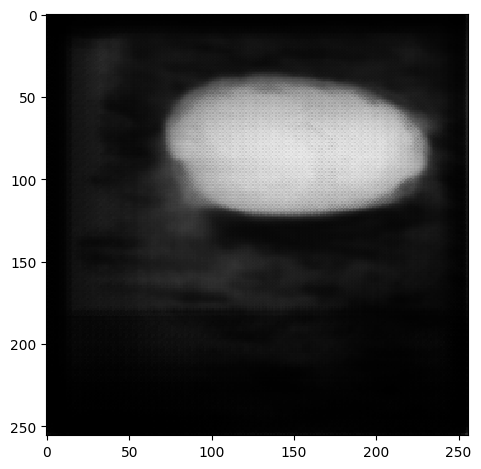

In [124]:
Predicted = model.predict(Xtest[:int(Xtest.shape[0])])

def mse(img1, img2):
   err = np.sum((img1.astype("float") - img2.astype("float")) ** 2)
   err /= float(img1.shape[0] * img2.shape[1])
   return err

def mae(img1,img2):
    err = np.sum(abs(img1.astype("float") - img2.astype("float")))
    err /= float(img1.shape[0] * img2.shape[1])
    return err

ma_error=[]
ms_error=[]
rms_error=[]
psnr=[]

for i in range (30):
    e=mse(Predicted[i],Ytest[i])
    rms_error.append(np.sqrt(e))
    ms_error.append(e)
    val=255/e
    val=math.log(val,10)
    psnr.append(20*val)
    e=mae(Predicted[i],Ytest[i])
    ma_error.append(e)

avg_mse = np.average(ms_error)
avg_rmse  = np.average(rms_error)
avg_psnr = np.average(psnr)
avg_mae = np.average(ma_error)

print(avg_mae.round(decimals=5)," ",avg_mse.round(decimals=5)," ",avg_rmse.round(decimals=5)," ",avg_psnr.round(decimals=5))


ix = random.randint(0, len(Predicted)-1)
imshow(Xtest[ix])
plt.show()
imshow(Ytest[ix])
plt.show()
y=Predicted[ix].astype(np.float32)
imshow(y)
plt.show()